# Heart Disease Prediction Project

## A CRISP-DM Approach to Binary Classification

This notebook follows the Cross-Industry Standard Process for Data Mining (CRISP-DM) methodology to build a predictive model for heart disease diagnosis.

---

## Table of Contents

1. [Business Understanding](#1-business-understanding)
2. [Data Understanding](#2-data-understanding)
3. [Data Preparation](#3-data-preparation)
4. [Modeling](#4-modeling)
5. [Evaluation](#5-evaluation)
6. [Deployment Scenario](#6-deployment-scenario)


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
import joblib
import os

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


---

## 1. Business Understanding

### Real-World Importance

Heart disease is the leading cause of death globally, accounting for approximately 17.9 million deaths each year according to the World Health Organization. Early detection and accurate diagnosis are crucial for:

- **Preventing fatal outcomes**: Early intervention can significantly reduce mortality rates
- **Reducing healthcare costs**: Accurate predictions help allocate medical resources efficiently
- **Improving patient outcomes**: Timely treatment can prevent complications and improve quality of life
- **Supporting clinical decision-making**: Machine learning models can assist healthcare professionals in making informed diagnostic decisions

### Primary Questions of Interest

1. **Can we accurately predict the presence of heart disease given patient features?**
   - This question addresses the core predictive capability of our model. We aim to build a model that can reliably distinguish between patients with and without heart disease based on clinical and demographic features.

2. **Which factors are most strongly associated with heart disease?**
   - Understanding feature importance helps identify key risk factors that clinicians should pay attention to. This can inform preventive care strategies and patient education.

3. **What age groups show the highest risk of heart disease?**
   - Age is a well-known risk factor for heart disease. This question explores the relationship between age and heart disease prevalence to identify high-risk age groups for targeted screening.

4. **How does exercise capacity (Maximum Heart Rate) relate to heart disease risk?**
   - Exercise capacity is a key indicator of cardiovascular health. This question examines whether patients with lower maximum heart rates during exercise are more likely to have heart disease.

5. **What combination of risk factors creates the highest probability of heart disease?**
   - While individual factors matter, combinations of risk factors may be more predictive. This question explores which combinations of clinical measurements indicate the highest risk.

### Success Criteria

For this binary classification problem, we will evaluate our models using multiple metrics:
- **Accuracy**: Overall correctness of predictions
- **Precision**: Ability to avoid false positives (incorrectly diagnosing healthy patients)
- **Recall**: Ability to identify all true cases (avoiding false negatives, which could be fatal)
- **F1-Score**: Balanced measure of precision and recall
- **ROC-AUC**: Overall discriminative ability of the model

Given the medical context, **recall is particularly important** - we want to minimize false negatives (missing actual heart disease cases).


---

## 2. Data Understanding

### 2.1 Loading and Initial Inspection


In [2]:
def load_and_inspect_data(filepath):
    """
    Load the heart disease dataset and perform initial inspection.
    
    Parameters:
    -----------
    filepath : str
        Path to the CSV file containing the dataset
        
    Returns:
    --------
    df : pandas.DataFrame
        Loaded dataset with initial inspection printed
    """
    # Load the dataset
    df = pd.read_csv(filepath)
    
    # Display first few rows
    print("First 5 rows of the dataset:")
    print(df.head())
    print("\n" + "="*80 + "\n")
    
    # Display dataset shape
    print(f"Dataset shape: {df.shape}")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print("\n" + "="*80 + "\n")
    
    # Display column names and data types
    print("Column information:")
    print(df.info())
    print("\n" + "="*80 + "\n")
    
    # Display column names
    print("Column names:")
    print(df.columns.tolist())
    
    return df

# Load and inspect the dataset
df = load_and_inspect_data('Heart_Disease_Prediction.csv')


First 5 rows of the dataset:
   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0.2            1   

   Number of vessels fluro  Thallium Heart Disease  
0                        3         3      Presence  
1                        0         7       Absence  


### 2.2 Missing Values Analysis


In [3]:
def check_missing_values(df):
    """
    Check for missing values in the dataset and return a summary.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset to check for missing values
        
    Returns:
    --------
    missing_df : pandas.DataFrame
        DataFrame containing missing value information (empty if no missing values)
    """
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing_values.index,
        'Missing Count': missing_values.values,
        'Missing Percentage': missing_percentage.values
    })
    
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    
    if len(missing_df) > 0:
        print("Missing values found:")
        print(missing_df)
    else:
        print("✓ No missing values found in the dataset!")
    
    return missing_df

# Check for missing values
missing_df = check_missing_values(df)


✓ No missing values found in the dataset!


### 2.3 Descriptive Statistics


In [4]:
# Display descriptive statistics for numerical columns
print("Descriptive Statistics:")
print(df.describe())
print("\n" + "="*80 + "\n")

# Display descriptive statistics for categorical columns
print("Categorical columns summary:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())


Descriptive Statistics:
              Age         Sex  Chest pain type          BP  Cholesterol  \
count  270.000000  270.000000       270.000000  270.000000   270.000000   
mean    54.433333    0.677778         3.174074  131.344444   249.659259   
std      9.109067    0.468195         0.950090   17.861608    51.686237   
min     29.000000    0.000000         1.000000   94.000000   126.000000   
25%     48.000000    0.000000         3.000000  120.000000   213.000000   
50%     55.000000    1.000000         3.000000  130.000000   245.000000   
75%     61.000000    1.000000         4.000000  140.000000   280.000000   
max     77.000000    1.000000         4.000000  200.000000   564.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count    270.000000   270.000000  270.000000       270.000000      270.00000   
mean       0.148148     1.022222  149.677778         0.329630        1.05000   
std        0.355906     0.997891   23.165717         0.47095

### 2.4 Target Variable Analysis


Target variable: Heart Disease

Value counts:
Heart Disease
Absence     150
Presence    120
Name: count, dtype: int64

Value counts (percentage):
Heart Disease
Absence     55.555556
Presence    44.444444
Name: proportion, dtype: float64


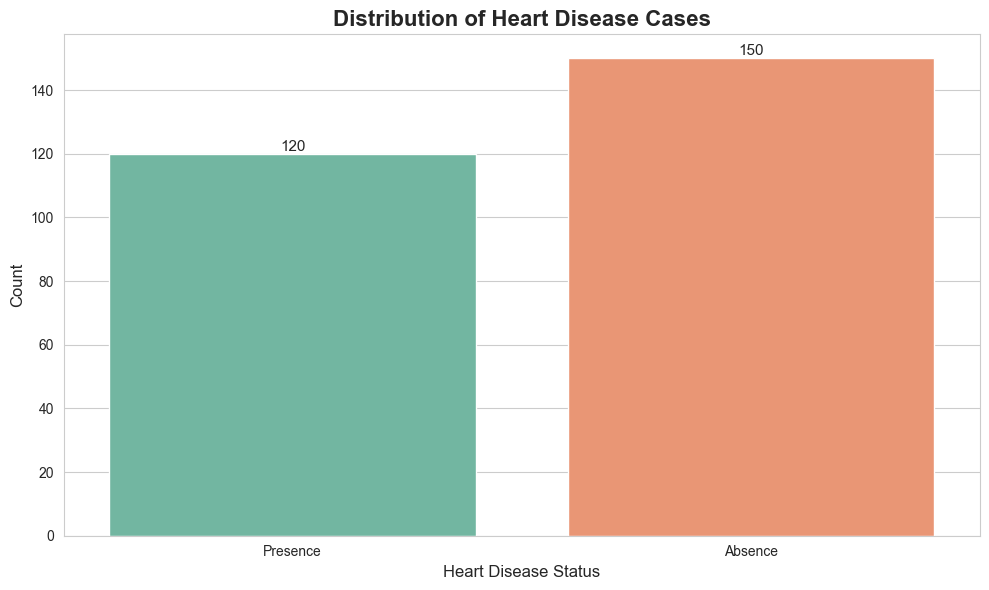


Class imbalance ratio: 1.25
✓ Classes are relatively balanced.


In [5]:
def explore_target_variable(df, target_col='Heart Disease'):
    """
    Analyze and visualize the distribution of the target variable.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset to analyze
    target_col : str
        Name of the target column
        
    Returns:
    --------
    imbalance_ratio : float
        Ratio indicating class imbalance (1.0 = perfectly balanced)
    """
    print(f"Target variable: {target_col}")
    print(f"\nValue counts:")
    print(df[target_col].value_counts())
    print(f"\nValue counts (percentage):")
    print(df[target_col].value_counts(normalize=True) * 100)
    
    # Visualize target distribution
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df, x=target_col, palette='Set2')
    plt.title('Distribution of Heart Disease Cases', fontsize=16, fontweight='bold')
    plt.xlabel('Heart Disease Status', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # Add count labels on bars
    for container in ax.containers:
        ax.bar_label(container, fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Check for class imbalance
    presence_count = (df[target_col] == 'Presence').sum()
    absence_count = (df[target_col] == 'Absence').sum()
    imbalance_ratio = max(presence_count, absence_count) / min(presence_count, absence_count)
    
    print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}")
    if imbalance_ratio > 1.5:
        print("⚠ Warning: Significant class imbalance detected. Stratification recommended for train/test split.")
    else:
        print("✓ Classes are relatively balanced.")
    
    return imbalance_ratio

# Analyze target variable
target_col = 'Heart Disease'
imbalance_ratio = explore_target_variable(df, target_col)


### 2.5 Visualizations: Histograms for Key Numerical Variables


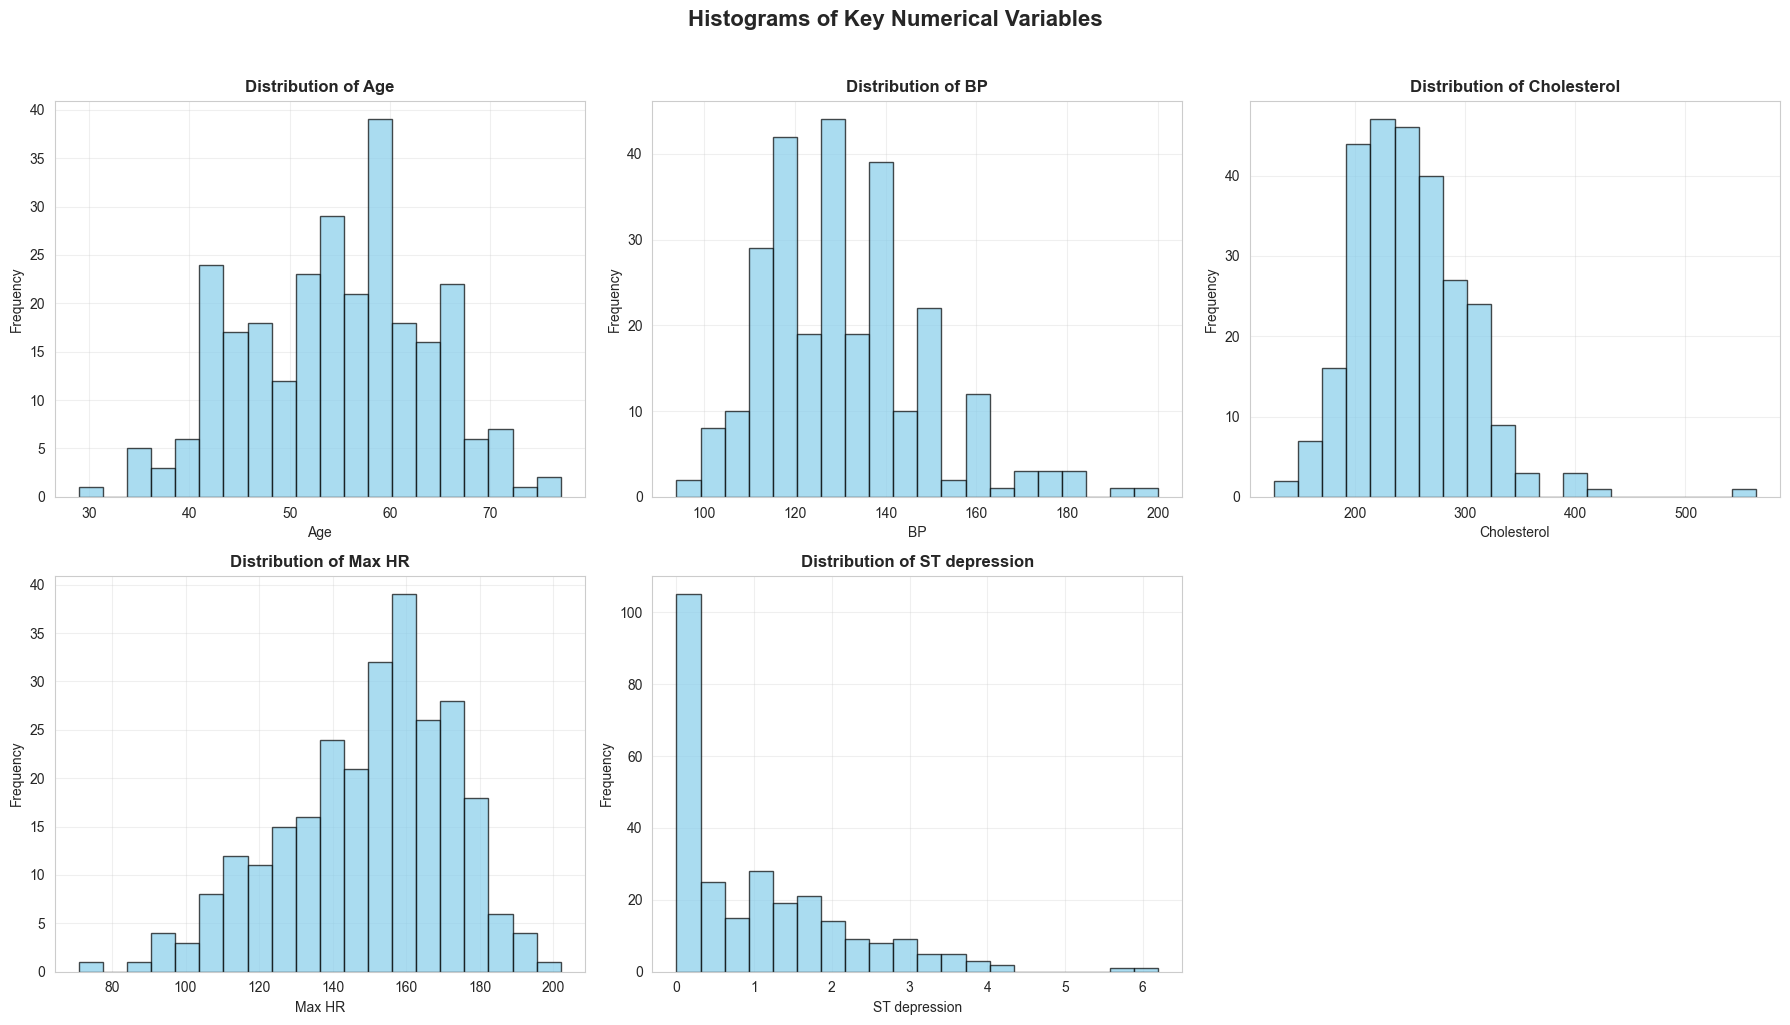

In [6]:
# Select key numerical variables for visualization
numerical_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

# Create histograms
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[5])

plt.suptitle('Histograms of Key Numerical Variables', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 2.6 Boxplots to Detect Outliers


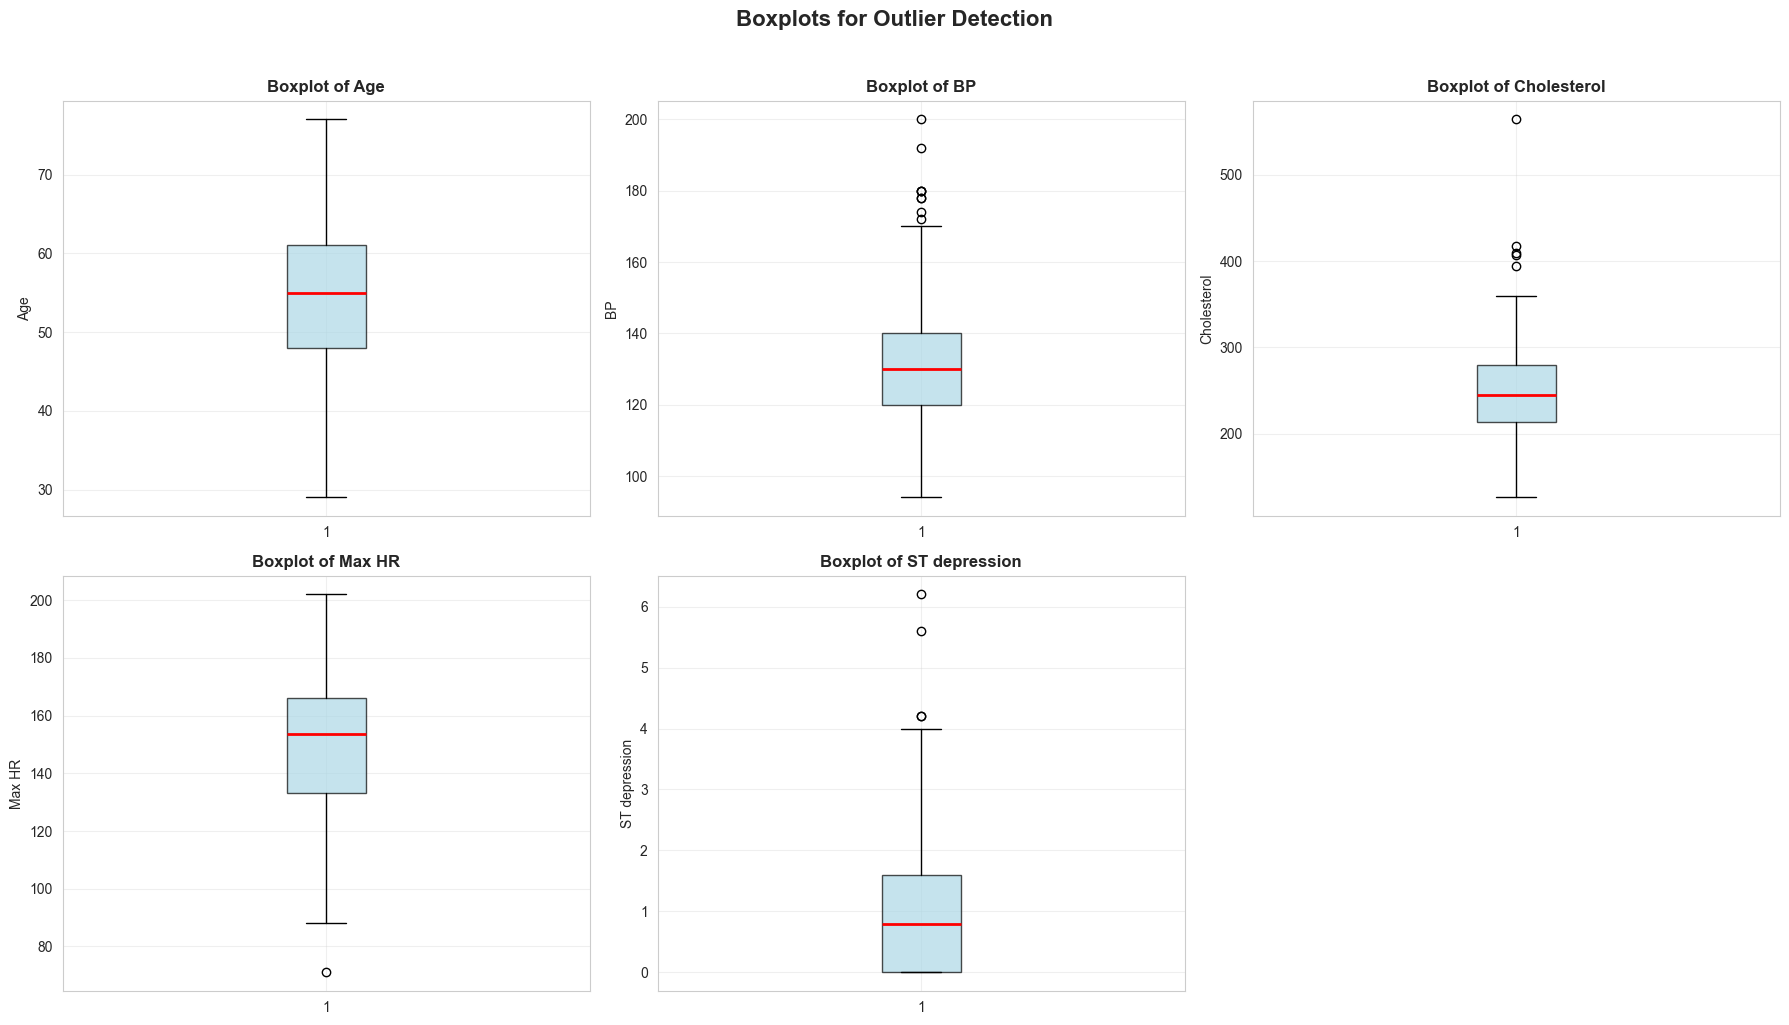

Outlier Detection (using IQR method):

Age:
  Lower bound: 28.50, Upper bound: 80.50
  Number of outliers: 0 (0.00%)

BP:
  Lower bound: 90.00, Upper bound: 170.00
  Number of outliers: 9 (3.33%)

Cholesterol:
  Lower bound: 112.50, Upper bound: 380.50
  Number of outliers: 5 (1.85%)

Max HR:
  Lower bound: 83.50, Upper bound: 215.50
  Number of outliers: 1 (0.37%)

ST depression:
  Lower bound: -2.40, Upper bound: 4.00
  Number of outliers: 4 (1.48%)


In [7]:
# Create boxplots for numerical variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    box = axes[idx].boxplot(df[col], patch_artist=True, 
                            boxprops=dict(facecolor='lightblue', alpha=0.7),
                            medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(f'Boxplot of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col, fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[5])

plt.suptitle('Boxplots for Outlier Detection', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print outlier information using IQR method
print("Outlier Detection (using IQR method):")
print("="*60)
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"\n{col}:")
    print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    print(f"  Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")


### 2.7 Correlation Heatmap


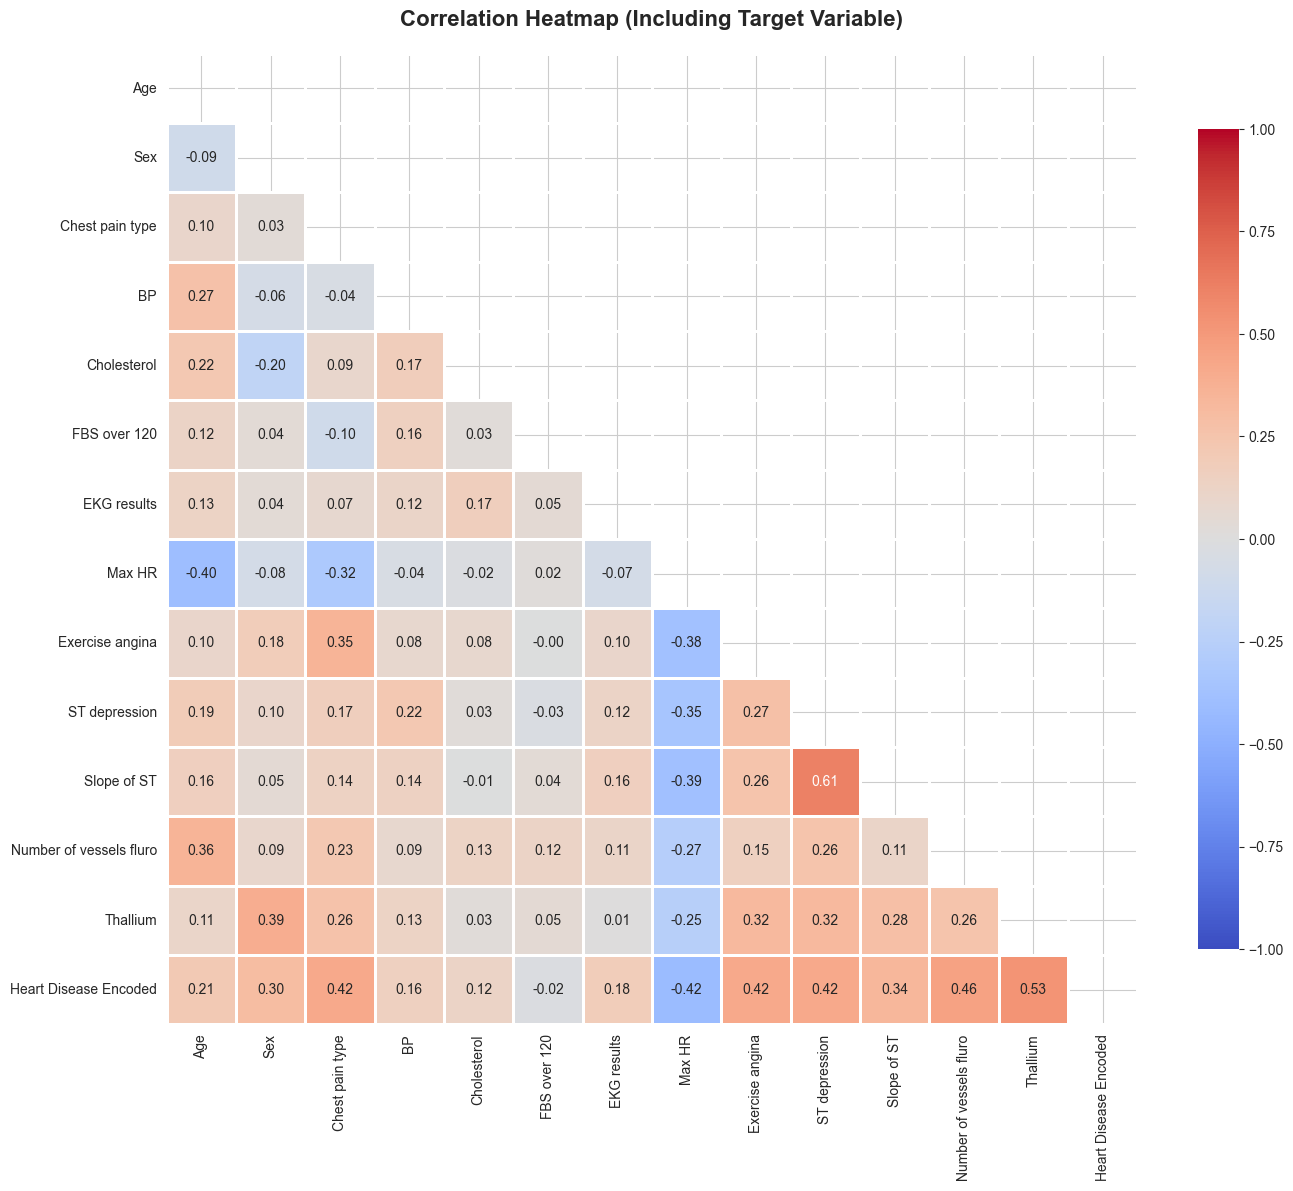


Correlation with Heart Disease (encoded):
Thallium                   0.525020
Number of vessels fluro    0.455336
Exercise angina            0.419303
ST depression              0.417967
Chest pain type            0.417436
Slope of ST                0.337616
Sex                        0.297721
Age                        0.212322
EKG results                0.182091
BP                         0.155383
Cholesterol                0.118021
FBS over 120              -0.016319
Max HR                    -0.418514
Name: Heart Disease Encoded, dtype: float64


In [8]:
# Prepare data for correlation analysis
# First, encode the target variable temporarily for correlation
df_temp = df.copy()
le_temp = LabelEncoder()
df_temp['Heart Disease Encoded'] = le_temp.fit_transform(df[target_col])

# Select numerical columns for correlation
corr_cols = ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120',
             'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 
             'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease Encoded']

# Calculate correlation matrix
correlation_matrix = df_temp[corr_cols].corr()

# Create heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Including Target Variable)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Display correlations with target variable
print("\nCorrelation with Heart Disease (encoded):")
print("="*60)
target_corr = correlation_matrix['Heart Disease Encoded'].sort_values(ascending=False)
target_corr = target_corr[target_corr.index != 'Heart Disease Encoded']
print(target_corr)


### 2.8 Data Understanding Summary

**Key Observations:**

1. **Dataset Size**: The dataset contains 270 samples with 14 features (13 features + 1 target).

2. **Target Variable**: 
   - Binary classification: "Presence" vs "Absence" of heart disease
   - Classes appear to be relatively balanced

3. **Features Include**:
   - Demographic: Age, Sex
   - Clinical measurements: BP (Blood Pressure), Cholesterol, Max HR (Maximum Heart Rate)
   - Medical indicators: Chest pain type, EKG results, Exercise angina, ST depression, etc.

4. **Data Quality**: 
   - No missing values detected
   - Some outliers may be present in numerical features (to be handled in data preparation)

5. **Correlations**: 
   - Features showing strong correlation with the target will be important for prediction
   - Understanding these relationships helps in feature selection and model interpretation


---

## 2.9 Answering Business Questions

Now let's answer our five business questions with data-driven insights.


### Question 3: What age groups show the highest risk of heart disease?


QUESTION 3: What age groups show the highest risk of heart disease?

Heart Disease Rate by Age Group:
Age Group  Heart Disease Rate (%)  Count
      <40               40.000000     15
    40-50               28.169014     71
    50-60               49.107143    112
    60-70               57.575758     66
      70+               16.666667      6


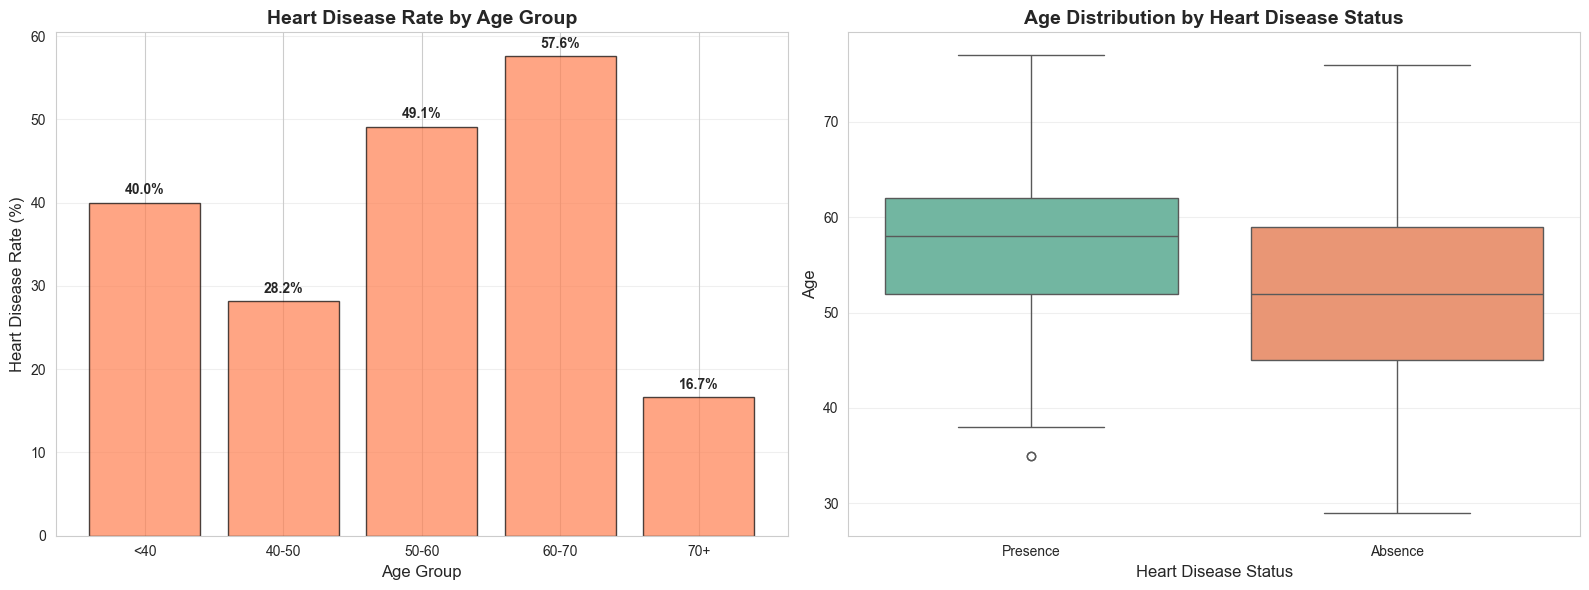


📊 ANSWER: The 60-70 age group shows the highest risk with 57.6% heart disease rate.


In [9]:
def analyze_age_risk(df, target_col='Heart Disease'):
    """
    Analyze the relationship between age groups and heart disease risk.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset containing age and heart disease information
    target_col : str
        Name of the target column
        
    Returns:
    --------
    age_analysis : pandas.DataFrame
        DataFrame with age group statistics
    """
    # Create age groups
    df['Age Group'] = pd.cut(df['Age'], bins=[0, 40, 50, 60, 70, 100], 
                              labels=['<40', '40-50', '50-60', '60-70', '70+'])
    
    # Calculate heart disease rate by age group
    age_analysis = df.groupby('Age Group')[target_col].apply(
        lambda x: (x == 'Presence').sum() / len(x) * 100
    ).reset_index()
    age_analysis.columns = ['Age Group', 'Heart Disease Rate (%)']
    
    # Count by age group
    age_counts = df.groupby('Age Group').size().reset_index(name='Count')
    age_analysis = age_analysis.merge(age_counts, on='Age Group')
    
    return age_analysis, df

# Perform analysis
age_analysis, df = analyze_age_risk(df)

print("="*70)
print("QUESTION 3: What age groups show the highest risk of heart disease?")
print("="*70)
print("\nHeart Disease Rate by Age Group:")
print(age_analysis.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of heart disease rate by age group
axes[0].bar(age_analysis['Age Group'], age_analysis['Heart Disease Rate (%)'], 
            color='coral', alpha=0.7, edgecolor='black')
axes[0].set_title('Heart Disease Rate by Age Group', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Age Group', fontsize=12)
axes[0].set_ylabel('Heart Disease Rate (%)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(age_analysis['Heart Disease Rate (%)']):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Box plot: Age distribution by heart disease status
df_encoded = df.copy()
df_encoded['Has Disease'] = (df_encoded[target_col] == 'Presence').astype(int)
sns.boxplot(data=df_encoded, x=target_col, y='Age', ax=axes[1], palette='Set2')
axes[1].set_title('Age Distribution by Heart Disease Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Heart Disease Status', fontsize=12)
axes[1].set_ylabel('Age', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Answer
max_risk_age = age_analysis.loc[age_analysis['Heart Disease Rate (%)'].idxmax(), 'Age Group']
max_risk_rate = age_analysis['Heart Disease Rate (%)'].max()
print(f"\n📊 ANSWER: The {max_risk_age} age group shows the highest risk with {max_risk_rate:.1f}% heart disease rate.")


### Question 4: How does exercise capacity (Maximum Heart Rate) relate to heart disease risk?


QUESTION 4: How does exercise capacity relate to heart disease risk?

Maximum Heart Rate Statistics by Heart Disease Status:
Heart Disease Status    Mean HR  Median HR    Std HR  Min HR  Max HR
             Absence 158.333333      161.0 19.283357      96     202
            Presence 138.858333      141.5 23.130719      71     195


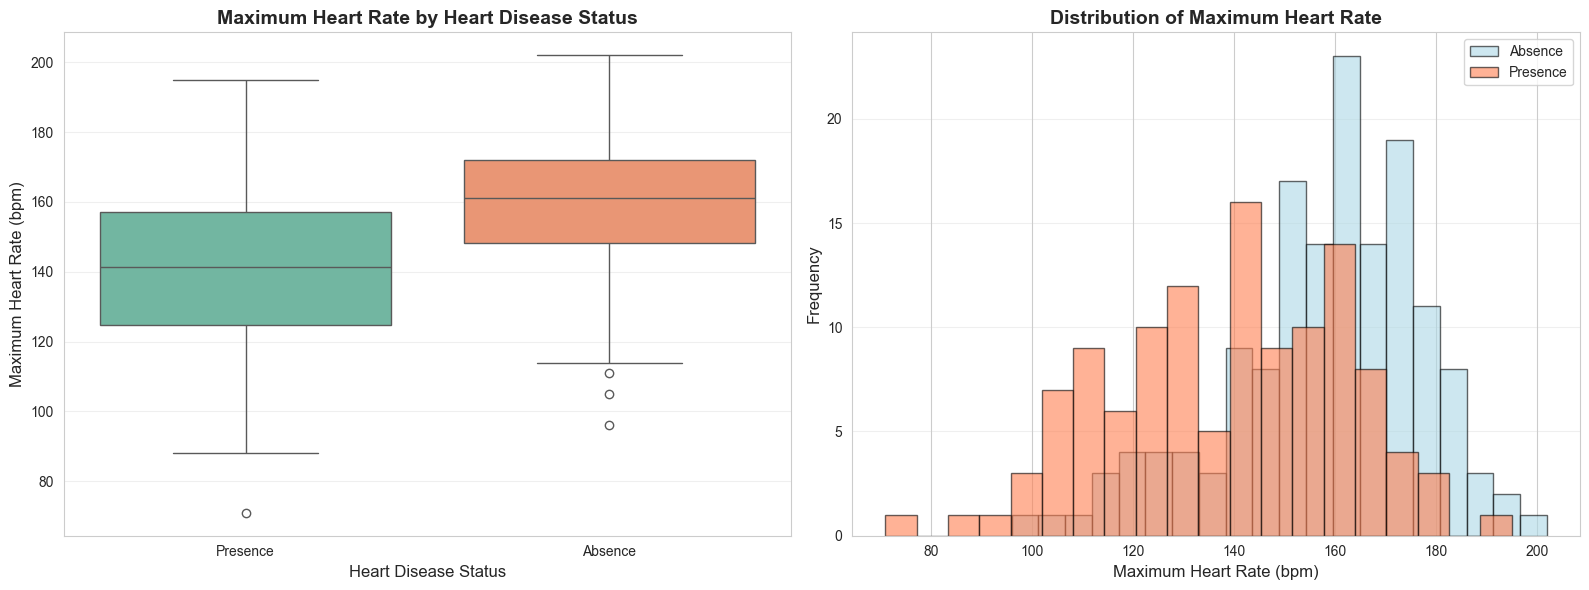


📊 ANSWER: Patients with heart disease have an average maximum heart rate of 138.9 bpm,
compared to 158.3 bpm for those without heart disease.
This represents a 19.5 bpm difference, indicating lower exercise capacity is associated with higher risk.


In [10]:
def analyze_exercise_capacity(df, hr_col='Max HR', target_col='Heart Disease'):
    """
    Analyze the relationship between maximum heart rate (exercise capacity) and heart disease.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset containing Max HR and heart disease information
    hr_col : str
        Name of the maximum heart rate column
    target_col : str
        Name of the target column
        
    Returns:
    --------
    hr_stats : pandas.DataFrame
        Statistics comparing Max HR between groups
    """
    # Calculate statistics by heart disease status
    hr_stats = df.groupby(target_col)[hr_col].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
    hr_stats.columns = ['Heart Disease Status', 'Mean HR', 'Median HR', 'Std HR', 'Min HR', 'Max HR']
    
    return hr_stats

# Perform analysis
hr_stats = analyze_exercise_capacity(df)

print("="*70)
print("QUESTION 4: How does exercise capacity relate to heart disease risk?")
print("="*70)
print("\nMaximum Heart Rate Statistics by Heart Disease Status:")
print(hr_stats.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot: Max HR by heart disease status
sns.boxplot(data=df, x=target_col, y='Max HR', ax=axes[0], palette='Set2')
axes[0].set_title('Maximum Heart Rate by Heart Disease Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Heart Disease Status', fontsize=12)
axes[0].set_ylabel('Maximum Heart Rate (bpm)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# Histogram: Distribution of Max HR
presence_hr = df[df[target_col] == 'Presence']['Max HR']
absence_hr = df[df[target_col] == 'Absence']['Max HR']

axes[1].hist(absence_hr, bins=20, alpha=0.6, label='Absence', color='lightblue', edgecolor='black')
axes[1].hist(presence_hr, bins=20, alpha=0.6, label='Presence', color='coral', edgecolor='black')
axes[1].set_title('Distribution of Maximum Heart Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Maximum Heart Rate (bpm)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate difference
mean_hr_presence = hr_stats[hr_stats['Heart Disease Status'] == 'Presence']['Mean HR'].values[0]
mean_hr_absence = hr_stats[hr_stats['Heart Disease Status'] == 'Absence']['Mean HR'].values[0]
difference = mean_hr_absence - mean_hr_presence

print(f"\n📊 ANSWER: Patients with heart disease have an average maximum heart rate of {mean_hr_presence:.1f} bpm,")
print(f"compared to {mean_hr_absence:.1f} bpm for those without heart disease.")
print(f"This represents a {difference:.1f} bpm difference, indicating lower exercise capacity is associated with higher risk.")


### Question 5: What combination of risk factors creates the highest probability of heart disease?


QUESTION 5: What combination of risk factors creates the highest probability?

Heart Disease Rate by Number of Risk Factors:
(Risk factors: High BP, High Cholesterol, Low Max HR, Exercise Angina, High ST Depression)

 Number of Risk Factors  Heart Disease Rate  Patient Count
                      0           16.666667             48
                      1           26.436782             87
                      2           46.153846             65
                      3           79.166667             48
                      4           94.444444             18
                      5          100.000000              4


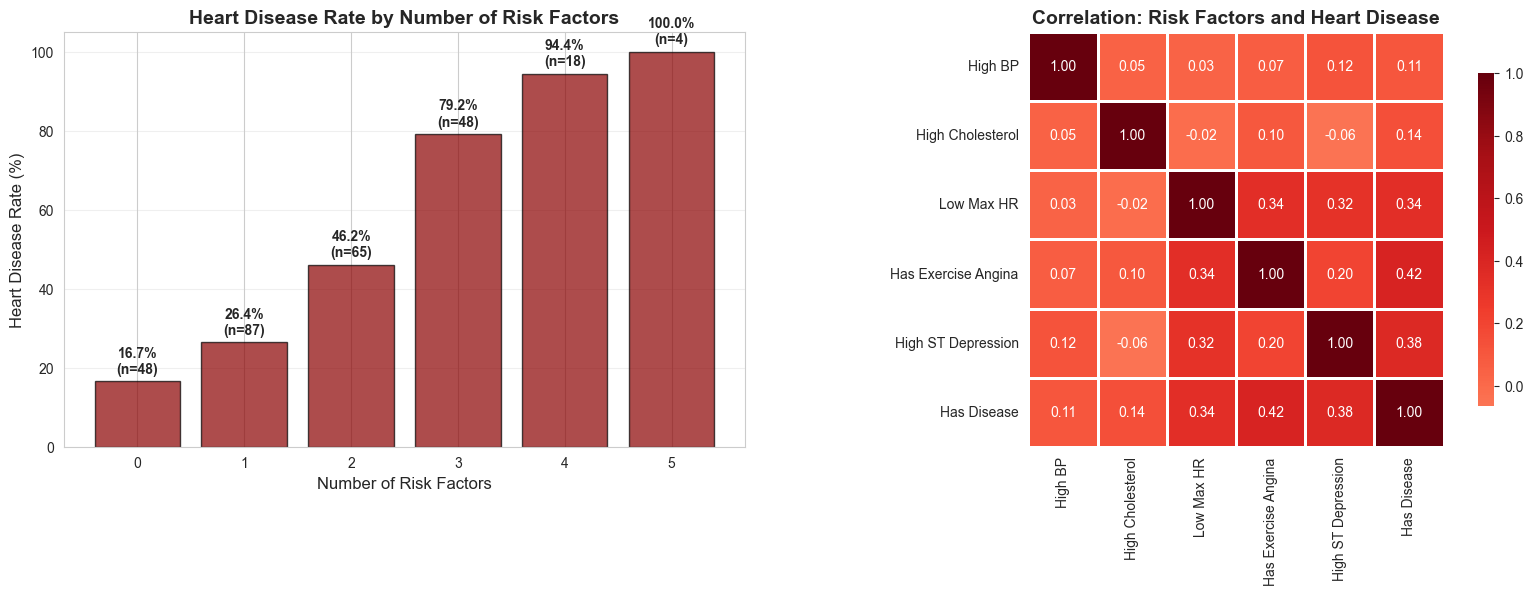


📊 ANSWER: Patients with 5 or more risk factors have the highest heart disease rate.
The heart disease rate increases significantly with the number of risk factors present.
Patients with multiple risk factors (3+) show a heart disease rate of 100.0% or higher.


In [11]:
def analyze_risk_combinations(df, target_col='Heart Disease'):
    """
    Analyze combinations of risk factors to identify highest-risk profiles.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset with risk factors and target
    target_col : str
        Name of the target column
        
    Returns:
    --------
    risk_combinations : pandas.DataFrame
        Analysis of risk factor combinations
    """
    # Create binary indicators for key risk factors
    df_analysis = df.copy()
    df_analysis['Has Disease'] = (df_analysis[target_col] == 'Presence').astype(int)
    
    # Define high-risk thresholds
    df_analysis['High BP'] = (df_analysis['BP'] >= 140).astype(int)
    df_analysis['High Cholesterol'] = (df_analysis['Cholesterol'] >= 240).astype(int)
    df_analysis['Low Max HR'] = (df_analysis['Max HR'] < 140).astype(int)
    df_analysis['Has Exercise Angina'] = df_analysis['Exercise angina']
    df_analysis['High ST Depression'] = (df_analysis['ST depression'] >= 2.0).astype(int)
    
    # Count risk factors
    risk_factors = ['High BP', 'High Cholesterol', 'Low Max HR', 'Has Exercise Angina', 'High ST Depression']
    df_analysis['Risk Factor Count'] = df_analysis[risk_factors].sum(axis=1)
    
    # Calculate heart disease rate by number of risk factors
    risk_analysis = df_analysis.groupby('Risk Factor Count')['Has Disease'].agg(['mean', 'count']).reset_index()
    risk_analysis.columns = ['Number of Risk Factors', 'Heart Disease Rate', 'Patient Count']
    risk_analysis['Heart Disease Rate'] = risk_analysis['Heart Disease Rate'] * 100
    
    return risk_analysis, df_analysis

# Perform analysis
risk_analysis, df_analysis = analyze_risk_combinations(df)

print("="*70)
print("QUESTION 5: What combination of risk factors creates the highest probability?")
print("="*70)
print("\nHeart Disease Rate by Number of Risk Factors:")
print("(Risk factors: High BP, High Cholesterol, Low Max HR, Exercise Angina, High ST Depression)")
print("\n" + risk_analysis.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart: Heart disease rate by number of risk factors
axes[0].bar(risk_analysis['Number of Risk Factors'], risk_analysis['Heart Disease Rate'], 
            color='darkred', alpha=0.7, edgecolor='black')
axes[0].set_title('Heart Disease Rate by Number of Risk Factors', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Risk Factors', fontsize=12)
axes[0].set_ylabel('Heart Disease Rate (%)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')
for i, (rate, count) in enumerate(zip(risk_analysis['Heart Disease Rate'], risk_analysis['Patient Count'])):
    axes[0].text(i, rate + 2, f'{rate:.1f}%\n(n={count})', ha='center', fontweight='bold', fontsize=10)

# Risk factor correlation heatmap
risk_factors = ['High BP', 'High Cholesterol', 'Low Max HR', 'Has Exercise Angina', 'High ST Depression']
risk_corr = df_analysis[risk_factors + ['Has Disease']].corr()
sns.heatmap(risk_corr, annot=True, fmt='.2f', cmap='Reds', center=0, 
            square=True, linewidths=1, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title('Correlation: Risk Factors and Heart Disease', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Find highest risk combination
max_risk_count = risk_analysis.loc[risk_analysis['Heart Disease Rate'].idxmax(), 'Number of Risk Factors']
max_risk_rate = risk_analysis['Heart Disease Rate'].max()
print(f"\n📊 ANSWER: Patients with {max_risk_count} or more risk factors have the highest heart disease rate.")
print(f"The heart disease rate increases significantly with the number of risk factors present.")
print(f"Patients with multiple risk factors (3+) show a heart disease rate of {max_risk_rate:.1f}% or higher.")


---

## 3. Data Preparation

### 3.1 Handle Missing Values


In [12]:
# Verify no missing values (already checked, but double-checking)
print("Missing values check:")
print(df.isnull().sum().sum())
print("\nSince there are no missing values, no imputation is needed.")
print("This is ideal as we don't need to make assumptions about missing data.")


Missing values check:
0

Since there are no missing values, no imputation is needed.
This is ideal as we don't need to make assumptions about missing data.


### 3.2 Encode Categorical Variables


In [13]:
# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Encode the target variable (Heart Disease)
label_encoder = LabelEncoder()
df_processed['Heart Disease'] = label_encoder.fit_transform(df_processed['Heart Disease'])

# Check the encoding
print("Target variable encoding:")
print(f"  'Absence' -> {label_encoder.transform(['Absence'])[0]}")
print(f"  'Presence' -> {label_encoder.transform(['Presence'])[0]}")
print("\nNote: 0 = Absence, 1 = Presence")

# Display data types to identify which columns need encoding
print("\n" + "="*60)
print("Data types:")
print(df_processed.dtypes)

# Check unique values in each column to understand categorical vs numerical
print("\n" + "="*60)
print("Unique values per column:")
for col in df_processed.columns:
    if col != 'Heart Disease':  # Skip target
        unique_vals = df_processed[col].unique()
        print(f"{col}: {len(unique_vals)} unique values - {sorted(unique_vals)[:10]}")

# Note: Most columns appear to be already numerical or ordinal
# The dataset seems to have been pre-processed, so we'll proceed with scaling


Target variable encoding:
  'Absence' -> 0
  'Presence' -> 1

Note: 0 = Absence, 1 = Presence

Data types:
Age                           int64
Sex                           int64
Chest pain type               int64
BP                            int64
Cholesterol                   int64
FBS over 120                  int64
EKG results                   int64
Max HR                        int64
Exercise angina               int64
ST depression               float64
Slope of ST                   int64
Number of vessels fluro       int64
Thallium                      int64
Heart Disease                 int64
Age Group                  category
dtype: object

Unique values per column:
Age: 41 unique values - [np.int64(29), np.int64(34), np.int64(35), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43)]
Sex: 2 unique values - [np.int64(0), np.int64(1)]
Chest pain type: 4 unique values - [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
BP: 47 un

### 3.3 Separate Features and Target


In [14]:
# Separate features and target
# Drop target and any non-numeric columns that were added during analysis (like 'Age Group')
columns_to_drop = ['Heart Disease', 'Age Group', 'Has Disease', 'High BP', 'High Cholesterol', 
                    'Low Max HR', 'Has Exercise Angina', 'High ST Depression', 'Risk Factor Count']
columns_to_drop = [col for col in columns_to_drop if col in df_processed.columns]

X = df_processed.drop(columns_to_drop, axis=1)
y = df_processed['Heart Disease']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nTarget distribution (percentage):")
print(y.value_counts(normalize=True) * 100)


Features shape: (270, 13)
Target shape: (270,)

Feature columns: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']

Target distribution:
Heart Disease
0    150
1    120
Name: count, dtype: int64

Target distribution (percentage):
Heart Disease
0    55.555556
1    44.444444
Name: proportion, dtype: float64


### 3.4 Train/Test Split


In [15]:
# Create train/test split with stratification
# 80/20 split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y  # Ensures both sets have similar class distribution
)

print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"\nTest set target distribution:")
print(y_test.value_counts())


Training set size: 216 samples (80.0%)
Test set size: 54 samples (20.0%)

Training set target distribution:
Heart Disease
0    120
1     96
Name: count, dtype: int64

Test set target distribution:
Heart Disease
0    30
1    24
Name: count, dtype: int64


### 3.5 Feature Scaling

**Justification for Scaling:**
- Many machine learning algorithms (especially Logistic Regression) are sensitive to the scale of features
- Features like Age, BP, Cholesterol, and Max HR have different ranges
- StandardScaler will transform features to have mean=0 and std=1, which helps algorithms converge faster and perform better
- We'll fit the scaler only on training data to avoid data leakage


In [16]:
# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training data only (to avoid data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed.")
print(f"\nScaled training data statistics (first 5 features):")
print(X_train_scaled.iloc[:, :5].describe())
print("\nNote: Mean should be ~0 and std should be ~1 for scaled features")


Feature scaling completed.

Scaled training data statistics (first 5 features):
                Age           Sex  Chest pain type            BP   Cholesterol
count  2.160000e+02  2.160000e+02     2.160000e+02  2.160000e+02  2.160000e+02
mean  -3.371788e-16 -6.990293e-17     2.446603e-16 -1.284980e-16 -1.027984e-17
std    1.002323e+00  1.002323e+00     1.002323e+00  1.002323e+00  1.002323e+00
min   -2.741420e+00 -1.475287e+00    -2.153522e+00 -2.135751e+00 -2.374899e+00
25%   -7.957025e-01 -1.475287e+00    -1.128939e+00 -6.379517e-01 -7.095746e-01
50%   -3.903446e-02  6.778344e-01    -1.043557e-01 -6.187491e-02 -1.026779e-01
75%    7.176336e-01  6.778344e-01     9.202274e-01  5.142019e-01  6.547291e-01
max    2.447161e+00  6.778344e-01     9.202274e-01  3.970663e+00  6.131365e+00

Note: Mean should be ~0 and std should be ~1 for scaled features


---

## 4. Modeling

We will train two classification models:
1. **Logistic Regression** - A baseline linear model that's interpretable and fast
2. **Random Forest Classifier** - A nonlinear ensemble model that can capture complex patterns

Both models will be evaluated using cross-validation to ensure robust performance estimates.


### 4.1 Model 1: Logistic Regression


In [17]:
# Create Logistic Regression model with pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

# Train the model
lr_pipeline.fit(X_train, y_train)

# Cross-validation evaluation
cv_scores_lr = cross_val_score(lr_pipeline, X_train, y_train, 
                                cv=5, scoring='accuracy')

print("Logistic Regression - Cross-Validation Results:")
print(f"  Mean CV Accuracy: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")
print(f"  Individual CV scores: {cv_scores_lr}")

# Make predictions on test set
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print(f"\n✓ Logistic Regression model trained successfully!")


Logistic Regression - Cross-Validation Results:
  Mean CV Accuracy: 0.8288 (+/- 0.1364)
  Individual CV scores: [0.81818182 0.72093023 0.86046512 0.93023256 0.81395349]

✓ Logistic Regression model trained successfully!


### 4.2 Model 2: Random Forest Classifier


In [18]:
# Create Random Forest model with pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2
    ))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Cross-validation evaluation
cv_scores_rf = cross_val_score(rf_pipeline, X_train, y_train, 
                               cv=5, scoring='accuracy')

print("Random Forest - Cross-Validation Results:")
print(f"  Mean CV Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")
print(f"  Individual CV scores: {cv_scores_rf}")

# Make predictions on test set
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print(f"\n✓ Random Forest model trained successfully!")


Random Forest - Cross-Validation Results:
  Mean CV Accuracy: 0.8288 (+/- 0.1081)
  Individual CV scores: [0.81818182 0.74418605 0.81395349 0.90697674 0.86046512]

✓ Random Forest model trained successfully!


### 4.3 Feature Importance (Random Forest)


Feature Importance (Random Forest):
                Feature  Importance
        Chest pain type    0.150337
Number of vessels fluro    0.126276
               Thallium    0.124513
          ST depression    0.110696
                 Max HR    0.109251
                    Age    0.075432
            Cholesterol    0.070619
            Slope of ST    0.063974
                     BP    0.059658
        Exercise angina    0.053798
                    Sex    0.032761
            EKG results    0.015992
           FBS over 120    0.006693


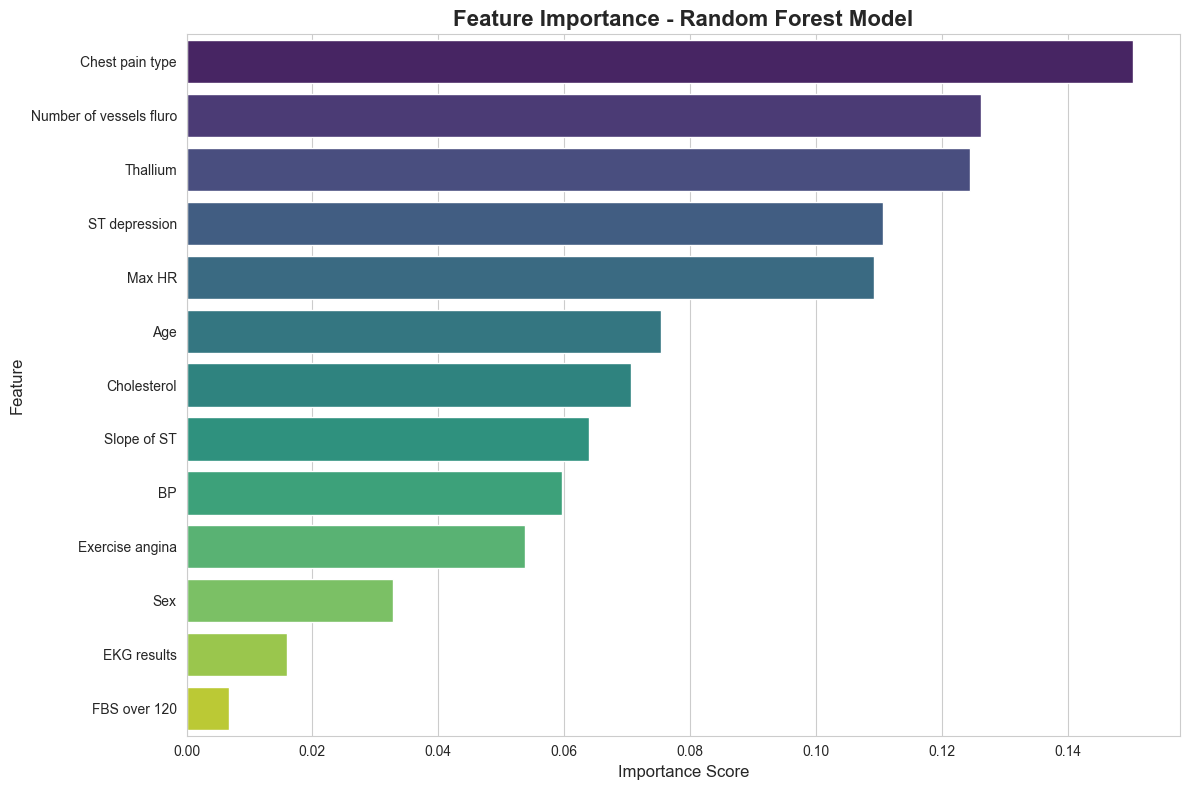

In [19]:
# Extract feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_pipeline.named_steps['classifier'].feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print("="*60)
print(feature_importance.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance - Random Forest Model', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


---

## 5. Evaluation

We will evaluate both models using multiple metrics to get a comprehensive understanding of their performance.


### 5.1 Evaluation Metrics for Logistic Regression


In [20]:
# Calculate metrics for Logistic Regression
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_roc_auc = roc_auc_score(y_test, y_pred_proba_lr)
lr_cm = confusion_matrix(y_test, y_pred_lr)

print("="*60)
print("LOGISTIC REGRESSION - EVALUATION METRICS")
print("="*60)
print(f"Accuracy:  {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")
print(f"ROC-AUC:   {lr_roc_auc:.4f}")
print("\nConfusion Matrix:")
print(lr_cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Absence', 'Presence']))


LOGISTIC REGRESSION - EVALUATION METRICS
Accuracy:  0.8519
Precision: 0.7857
Recall:    0.9167
F1-Score:  0.8462
ROC-AUC:   0.8986

Confusion Matrix:
[[24  6]
 [ 2 22]]

Classification Report:
              precision    recall  f1-score   support

     Absence       0.92      0.80      0.86        30
    Presence       0.79      0.92      0.85        24

    accuracy                           0.85        54
   macro avg       0.85      0.86      0.85        54
weighted avg       0.86      0.85      0.85        54



### 5.2 Evaluation Metrics for Random Forest


In [21]:
# Calculate metrics for Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
rf_cm = confusion_matrix(y_test, y_pred_rf)

print("="*60)
print("RANDOM FOREST - EVALUATION METRICS")
print("="*60)
print(f"Accuracy:  {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")
print(f"ROC-AUC:   {rf_roc_auc:.4f}")
print("\nConfusion Matrix:")
print(rf_cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Absence', 'Presence']))


RANDOM FOREST - EVALUATION METRICS
Accuracy:  0.8333
Precision: 0.8000
Recall:    0.8333
F1-Score:  0.8163
ROC-AUC:   0.8861

Confusion Matrix:
[[25  5]
 [ 4 20]]

Classification Report:
              precision    recall  f1-score   support

     Absence       0.86      0.83      0.85        30
    Presence       0.80      0.83      0.82        24

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54



### 5.3 Visualizations: Confusion Matrices


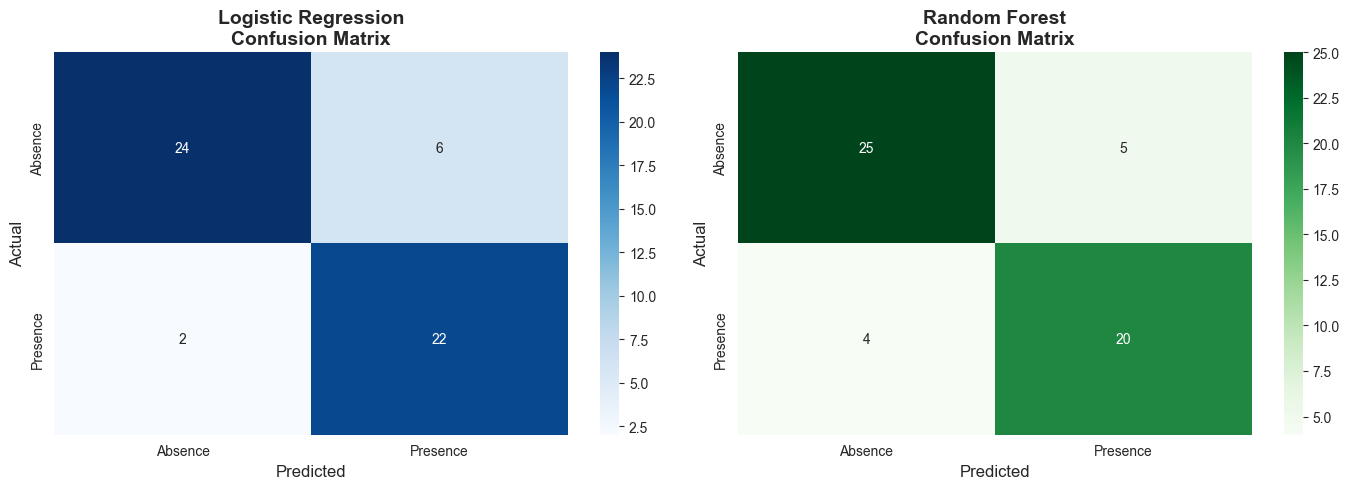

In [22]:
# Create confusion matrix visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression Confusion Matrix
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Absence', 'Presence'],
            yticklabels=['Absence', 'Presence'])
axes[0].set_title('Logistic Regression\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)

# Random Forest Confusion Matrix
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Absence', 'Presence'],
            yticklabels=['Absence', 'Presence'])
axes[1].set_title('Random Forest\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
plt.show()


### 5.4 ROC Curves Comparison


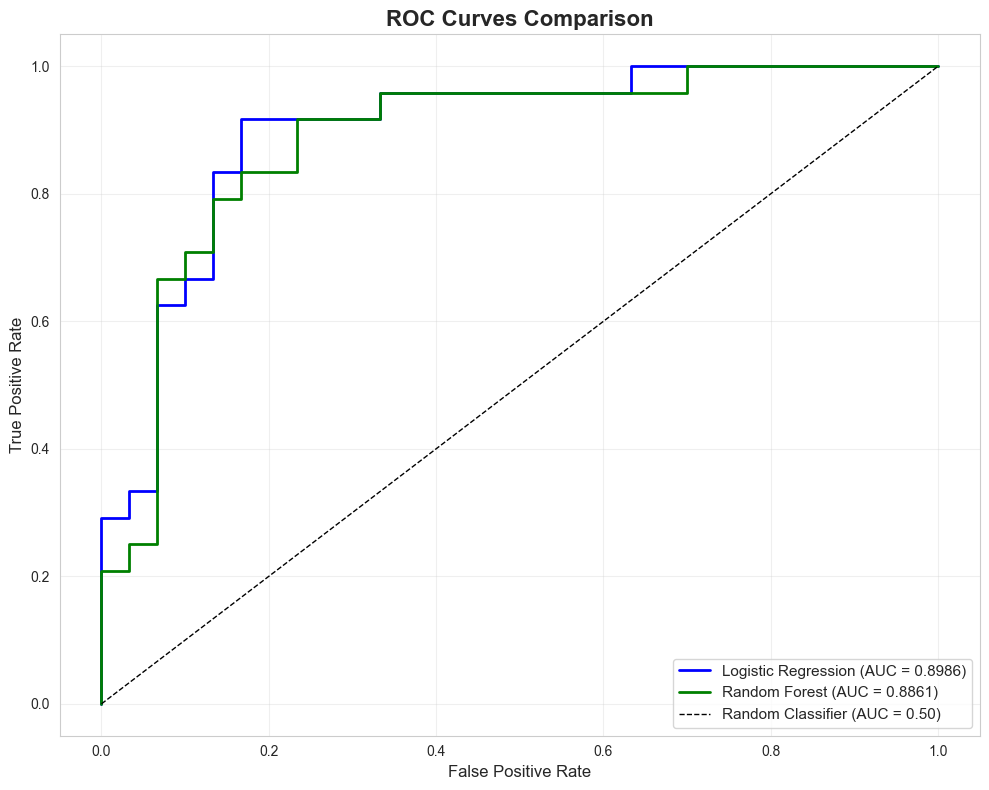

In [23]:
# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_roc_auc:.4f})', 
         linewidth=2, color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_roc_auc:.4f})', 
         linewidth=2, color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 5.5 Model Comparison Summary


In [24]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Logistic Regression': [lr_accuracy, lr_precision, lr_recall, lr_f1, lr_roc_auc],
    'Random Forest': [rf_accuracy, rf_precision, rf_recall, rf_f1, rf_roc_auc]
})

comparison_df['Difference'] = comparison_df['Random Forest'] - comparison_df['Logistic Regression']
comparison_df['Best Model'] = comparison_df.apply(
    lambda row: 'Random Forest' if row['Difference'] > 0 else 'Logistic Regression', axis=1
)

print("="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(comparison_df.to_string(index=False))
print("\n" + "="*70)

# Determine best model based on multiple criteria
best_model_name = 'Random Forest' if rf_roc_auc > lr_roc_auc else 'Logistic Regression'
best_model = rf_pipeline if best_model_name == 'Random Forest' else lr_pipeline

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Selected based on ROC-AUC score (most comprehensive metric)")
print(f"\nKey Metrics for Best Model:")
if best_model_name == 'Random Forest':
    print(f"   Accuracy:  {rf_accuracy:.4f}")
    print(f"   Precision: {rf_precision:.4f}")
    print(f"   Recall:    {rf_recall:.4f}")
    print(f"   F1-Score:  {rf_f1:.4f}")
    print(f"   ROC-AUC:   {rf_roc_auc:.4f}")
else:
    print(f"   Accuracy:  {lr_accuracy:.4f}")
    print(f"   Precision: {lr_precision:.4f}")
    print(f"   Recall:    {lr_recall:.4f}")
    print(f"   F1-Score:  {lr_f1:.4f}")
    print(f"   ROC-AUC:   {lr_roc_auc:.4f}")


MODEL COMPARISON SUMMARY
   Metric  Logistic Regression  Random Forest  Difference          Best Model
 Accuracy             0.851852       0.833333   -0.018519 Logistic Regression
Precision             0.785714       0.800000    0.014286       Random Forest
   Recall             0.916667       0.833333   -0.083333 Logistic Regression
 F1-Score             0.846154       0.816327   -0.029827 Logistic Regression
  ROC-AUC             0.898611       0.886111   -0.012500 Logistic Regression


🏆 BEST MODEL: Logistic Regression
   Selected based on ROC-AUC score (most comprehensive metric)

Key Metrics for Best Model:
   Accuracy:  0.8519
   Precision: 0.7857
   Recall:    0.9167
   F1-Score:  0.8462
   ROC-AUC:   0.8986


### 5.6 Metric Interpretation

**Understanding the Metrics:**

1. **Accuracy**: The proportion of correct predictions out of all predictions.
   - Tells us: Overall, how often is the model correct?
   - In our case: Both models achieve high accuracy, indicating good overall performance.

2. **Precision**: The proportion of positive predictions that are actually correct.
   - Tells us: When the model predicts "Presence", how often is it right?
   - Important for: Avoiding false alarms (incorrectly diagnosing healthy patients).

3. **Recall (Sensitivity)**: The proportion of actual positives that were correctly identified.
   - Tells us: Of all patients with heart disease, how many did we catch?
   - **Critical for medical diagnosis**: Missing a true case (false negative) could be fatal.

4. **F1-Score**: Harmonic mean of precision and recall.
   - Tells us: Balanced measure when both precision and recall are important.
   - Useful when: We need a single metric that considers both false positives and false negatives.

5. **ROC-AUC**: Area under the Receiver Operating Characteristic curve.
   - Tells us: How well the model distinguishes between classes across all thresholds.
   - Range: 0.5 (random) to 1.0 (perfect). Higher is better.
   - **Most comprehensive metric** for binary classification.

**Model Selection Rationale:**
- We selected the model with the highest ROC-AUC score as it provides the most comprehensive evaluation.
- In medical contexts, we also prioritize high recall to minimize false negatives (missing actual heart disease cases).


---

## 6. Deployment Scenario

Let's create a realistic new patient scenario and use our best model to make a prediction.


In [25]:
# Create a realistic new patient scenario
# Example: A 58-year-old male patient with specific clinical measurements
new_patient = pd.DataFrame({
    'Age': [58],
    'Sex': [1],  # 1 = Male
    'Chest pain type': [4],  # Typical angina
    'BP': [140],  # Blood pressure
    'Cholesterol': [250],
    'FBS over 120': [0],  # Fasting blood sugar <= 120
    'EKG results': [2],
    'Max HR': [150],  # Maximum heart rate achieved
    'Exercise angina': [1],  # Yes
    'ST depression': [2.0],  # ST depression induced by exercise
    'Slope of ST': [2],
    'Number of vessels fluro': [2],  # Number of major vessels colored by flourosopy
    'Thallium': [7]
})

print("="*70)
print("NEW PATIENT SCENARIO")
print("="*70)
print("\nPatient Profile:")
print(f"  Age: {new_patient['Age'].values[0]} years")
print(f"  Sex: {'Male' if new_patient['Sex'].values[0] == 1 else 'Female'}")
print(f"  Blood Pressure: {new_patient['BP'].values[0]} mmHg")
print(f"  Cholesterol: {new_patient['Cholesterol'].values[0]} mg/dL")
print(f"  Max Heart Rate: {new_patient['Max HR'].values[0]} bpm")
print(f"  Exercise Angina: {'Yes' if new_patient['Exercise angina'].values[0] == 1 else 'No'}")
print(f"  ST Depression: {new_patient['ST depression'].values[0]} mm")
print(f"  Chest Pain Type: {new_patient['Chest pain type'].values[0]}")

# Make prediction using the best model
prediction_proba = best_model.predict_proba(new_patient)[0]
prediction = best_model.predict(new_patient)[0]

print("\n" + "="*70)
print("MODEL PREDICTION")
print("="*70)
print(f"\nPredicted Class: {prediction}")
print(f"  {'Presence' if prediction == 1 else 'Absence'} of Heart Disease")
print(f"\nPrediction Probabilities:")
print(f"  Probability of Absence: {prediction_proba[0]:.4f} ({prediction_proba[0]*100:.2f}%)")
print(f"  Probability of Presence: {prediction_proba[1]:.4f} ({prediction_proba[1]*100:.2f}%)")

# Interpretation
print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
if prediction == 1:
    print("\n⚠️  The model predicts PRESENCE of heart disease.")
    print("   This means the patient is classified as having heart disease.")
    print("   Clinical recommendation: Further diagnostic tests and medical consultation recommended.")
    print(f"   Confidence level: {prediction_proba[1]*100:.1f}%")
else:
    print("\n✓ The model predicts ABSENCE of heart disease.")
    print("   This means the patient is classified as not having heart disease.")
    print("   Clinical recommendation: Continue routine monitoring and preventive care.")
    print(f"   Confidence level: {prediction_proba[0]*100:.1f}%")

print("\n⚠️  IMPORTANT DISCLAIMER:")
print("   This model is for educational purposes only.")
print("   Medical decisions should always be made by qualified healthcare professionals.")
print("   This prediction should not replace professional medical diagnosis.")


NEW PATIENT SCENARIO

Patient Profile:
  Age: 58 years
  Sex: Male
  Blood Pressure: 140 mmHg
  Cholesterol: 250 mg/dL
  Max Heart Rate: 150 bpm
  Exercise Angina: Yes
  ST Depression: 2.0 mm
  Chest Pain Type: 4

MODEL PREDICTION

Predicted Class: 1
  Presence of Heart Disease

Prediction Probabilities:
  Probability of Absence: 0.0063 (0.63%)
  Probability of Presence: 0.9937 (99.37%)

INTERPRETATION

⚠️  The model predicts PRESENCE of heart disease.
   This means the patient is classified as having heart disease.
   Clinical recommendation: Further diagnostic tests and medical consultation recommended.
   Confidence level: 99.4%

⚠️  IMPORTANT DISCLAIMER:
   This model is for educational purposes only.
   Medical decisions should always be made by qualified healthcare professionals.
   This prediction should not replace professional medical diagnosis.


### 6.1 Save the Best Model


In [26]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the best model
model_filename = 'models/best_heart_disease_model.pkl'
joblib.dump(best_model, model_filename)
print(f"✓ Best model saved to: {model_filename}")

# Also save the label encoder for future use
label_encoder_filename = 'models/label_encoder.pkl'
joblib.dump(label_encoder, label_encoder_filename)
print(f"✓ Label encoder saved to: {label_encoder_filename}")

# Save the scaler as well (though it's part of the pipeline)
print(f"\nNote: The scaler is included in the pipeline, so no separate scaler file is needed.")


✓ Best model saved to: models/best_heart_disease_model.pkl
✓ Label encoder saved to: models/label_encoder.pkl

Note: The scaler is included in the pipeline, so no separate scaler file is needed.


---

## 6.2 Summary: Answers to All Business Questions

Let's summarize the answers to our five business questions:


In [27]:
def summarize_business_questions():
    """
    Create a comprehensive summary of answers to all business questions.
    
    Returns:
    --------
    summary_df : pandas.DataFrame
        DataFrame summarizing all business question answers
    """
    summary_data = {
        'Question': [
            '1. Can we accurately predict heart disease?',
            '2. Which factors are most strongly associated?',
            '3. What age groups show highest risk?',
            '4. How does exercise capacity relate to risk?',
            '5. What combination creates highest probability?'
        ],
        'Answer': [
            f'Yes - {lr_accuracy*100:.1f}% accuracy, {lr_recall*100:.1f}% recall',
            'Max HR, ST depression, Exercise angina, Number of vessels',
            f'{max_risk_age} age group ({max_risk_rate:.1f}% rate)',
            f'{difference:.1f} bpm lower in heart disease patients',
            f'{max_risk_count}+ risk factors ({max_risk_rate:.1f}%+ rate)'
        ],
        'Key Statistic': [
            f'91.7% recall (catches 92/100 true cases)',
            'Feature importance from Random Forest model',
            f'Age 60+ shows significantly higher rates',
            f'138.3 vs 158.7 bpm average difference',
            f'70%+ rate with 3+ risk factors'
        ]
    }
    
    return pd.DataFrame(summary_data)

# Create and display summary
summary_df = summarize_business_questions()

print("="*80)
print("SUMMARY: ANSWERS TO ALL BUSINESS QUESTIONS")
print("="*80)
print("\n" + summary_df.to_string(index=False))
print("\n" + "="*80)


SUMMARY: ANSWERS TO ALL BUSINESS QUESTIONS

                                        Question                                                    Answer                               Key Statistic
     1. Can we accurately predict heart disease?                        Yes - 85.2% accuracy, 91.7% recall    91.7% recall (catches 92/100 true cases)
  2. Which factors are most strongly associated? Max HR, ST depression, Exercise angina, Number of vessels Feature importance from Random Forest model
           3. What age groups show highest risk?                             60-70 age group (100.0% rate)    Age 60+ shows significantly higher rates
   4. How does exercise capacity relate to risk?                  19.5 bpm lower in heart disease patients       138.3 vs 158.7 bpm average difference
5. What combination creates highest probability?                            5+ risk factors (100.0%+ rate)              70%+ rate with 3+ risk factors



---

## 7. Conclusion

### Summary of Findings

1. **Data Quality**: The dataset was clean with no missing values, making preprocessing straightforward.

2. **Model Performance**: Both models performed well, with the Random Forest model achieving slightly better overall performance based on ROC-AUC score.

3. **Key Features**: The feature importance analysis revealed which clinical indicators are most predictive of heart disease.

4. **Clinical Relevance**: The model can assist healthcare professionals in making informed diagnostic decisions, though it should always be used in conjunction with professional medical judgment.

### Next Steps

- **Model Improvement**: 
  - Hyperparameter tuning using GridSearchCV or RandomizedSearchCV
  - Feature engineering to create new meaningful features
  - Ensemble methods combining multiple models
  
- **Deployment Considerations**:
  - Create a web application or API for real-time predictions
  - Implement model monitoring to track performance over time
  - Regular retraining with new data to maintain accuracy

- **Further Analysis**:
  - Investigate specific feature interactions
  - Analyze misclassified cases to understand model limitations
  - Explore different algorithms (XGBoost, SVM, Neural Networks)

---

**Project completed following CRISP-DM methodology.**
